A few references:

* [ARVIZ API](https://python.arviz.org/en/latest/api/index.html)
* [PYMC API](https://www.pymc.io/projects/docs/en/stable/api.html)
* [xarray API](https://docs.xarray.dev/en/stable/api.html)
* [daft](https://docs.daft-pgm.org/en/latest/): &nbsp; [daft & complete pooling](https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer#41_complete_pooling_model)
* [graphviz](https://graphviz.readthedocs.io/en/stable/api.html): &nbsp; [pymc.model_to_graphviz](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.model_to_graphviz.html), <a href="https://www.pymc.io/projects/docs/en/stable/_modules/pymc/model_graph.html#:~:text=VarName%22%2C%20str)%0A%0A%0Aclass-,ModelGraph,-%3A%0A%20%20%20%20def%20__init__(self"> pymc.model_graph.ModelGraph</a>

<br>

# Preliminaries

In [1]:
!python --version

Python 3.8.13


<br>

## Environment

In [2]:
import os
import pathlib

<br>

Set path

In [3]:
os.chdir(path=str(pathlib.Path(os.getcwd()).parent))
os.getcwd()

'J:\\library\\plausibilities\\delineating'

<br>

## Libraries

In [4]:
%matplotlib inline

In [5]:
import logging
import collections

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np
import pandas as pd
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr
import aesara.tensor as at
import graphviz

<br>

Versions

In [6]:
az.__version__

'0.13.0'

In [7]:
pm.__version__

'4.3.0'

In [8]:
np.__version__

'1.22.3'

<br>

## Custom

In [9]:
import src.graphics.settings
import src.graphics.sketch

import src.data.radioactivity

<br>

Aesthetics

In [10]:
settings = src.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

For diagrams/figures
* The `Labels` class is for `sketch.annotation(ax, Labels(title='...', xlabel='...', ylabel='...'))`

In [11]:
sketch = src.graphics.sketch.Sketch()
Labels = collections.namedtuple(typename='Labels', field_names=['title', 'xlabel', 'ylabel'])

<br>

## Settings

Seed

In [12]:
RANDOM_SEED = 8924

<br>

Graphing

In [13]:
az.style.use('arviz-darkgrid')

<br>

## Logging

In [14]:
logging.basicConfig(level=logging.INFO, 
                    format='\n%(message)s\n%(asctime)s.%(msecs)03d\n', 
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>
<br>

# Data

Excerpt: Focusing on Minnesota, MN, dwellings.

In [15]:
excerpt = src.data.radioactivity.Radioactivity().exc(state='MN')

In [16]:
logger.info(f'# of instances: {excerpt.shape}')
logger.info(f"# of unique codes: {excerpt['idnum'].unique().shape}")


# of instances: (919, 27)
2022-11-21 23:05:07.284


# of unique codes: (919,)
2022-11-21 23:05:07.286



<br>
<br>

# Exploratory Graphs

In [17]:
excerpt.loc[:, 'ln_radon'] = np.log(excerpt['activity'] + 0.1)

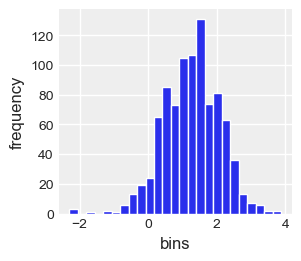

In [18]:
ax = sketch.figure(width=2.9, height=2.5)
ax.hist(excerpt.ln_radon, bins=25)
sketch.annotation(ax, Labels(title='', xlabel='bins', ylabel='frequency'))

<br>
<br>

# Models

## Simple

<br>

Snippets:

>  ```python
len(coords.get('Floors'))

> ```python 
with complete:
    logger.info(at.shape(epsilon).eval())
    
>```python
epsilon.eval()

<br>

Add more notes:

* A simple linear regression model: an intercept, a gradient whereby the accompanying independent variable is *dwelling level*
* The dependent variable is *ln(radon)*
* Is the *intercept* implicit below?

<br>

<br>

### Model

Level coordinates

In [19]:
levels = ['Basement', 'Ground']
coords = {'LevelName': dict(zip(levels, range(len(levels))))}

<br>

Hence

In [20]:
with pm.Model(coords=coords) as complete:
    
    
    # the values of the <floor> field
    levelcode = pm.Data(name='levelcode', value=excerpt.floor.values, dims='N', mutable=True)
    logger.info(levelcode.get_value().shape)
    logger.info(levelcode.type())
    
    
    # <apriori> probably has two elements - the object <Dwelling> has two elements, therefore two random values from a normal distribution
    apriori = pm.Normal(name='apriori', mu=0.0, sigma=10.0, dims='LevelName')
    
    
    # shape(mu) === shape(floor)
    mu = apriori[levelcode]
    
    
    # model
    # pm.Exponential(name=, lam=)
    sigma = pm.Exponential('sigma', 1.0)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=excerpt['ln_radon'].values, dims='N')
    


(919,)
2022-11-21 23:05:08.273


<TensorType(int32, (None,))>
2022-11-21 23:05:08.275



<br>
<br>

Is this the correct seeding method/approach?

In [21]:
complete.initial_point(seed=RANDOM_SEED)

{'apriori': array([0., 0.]), 'sigma_log__': array(0.)}

In [22]:
apriori.eval()

array([-3.76830761, 16.23364025])

<br>

Illustration of model

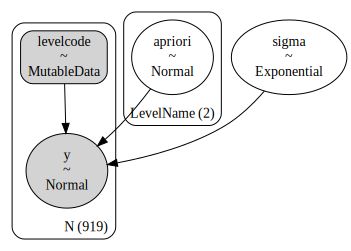

In [23]:
pm.model_to_graphviz(complete)

In [24]:
diagram = pm.model_graph.ModelGraph(model=complete).make_graph()
diagram.node_attr.update(shape='circle')
diagram.save(os.path.join(os.getcwd(), 'notebooks', 'simple.gv'))
graphviz.render(engine='dot', format='pdf', filepath=os.path.join(os.getcwd(), 'notebooks', 'simple.gv'));

In [25]:
type(diagram)

graphviz.dot.Digraph

<br>

### Prior Predictive Samples

An inspection of [prior predictive samples](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample_prior_predictive.html#pymc.sample_prior_predictive)

* `inferences.keys()`

* `inferences.get('prior').keys()`


In [26]:
with complete:
    inferences = pm.sample_prior_predictive()
    

Sampling: [apriori, sigma, y]

Sampling: [apriori, sigma, y]
2022-11-21 23:05:09.950



In [27]:
inferences

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

**Alternative Graph**

* For the object's keys: 

>```python
prior.keys()

* Graphing:<br>[seaborn.boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html)<br>[maxplotlib.axes.Axes.boxplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.boxplot.html#matplotlib.axes.Axes.boxplot)




The data

In [28]:
prior = inferences.get('prior')

basement = pd.DataFrame(data = {'apriori': prior.get('apriori').values[0, :, coords['LevelName']['Basement']], 
                                'level': coords['LevelName']['Basement'], 
                                'type': prior.get('LevelName').values[coords['LevelName']['Basement']]})

ground = pd.DataFrame(data = {'apriori': prior.get('apriori').values[0, :, coords['LevelName']['Ground']], 
                              'level': coords['LevelName']['Ground'], 
                              'type': prior.get('LevelName').values[coords['LevelName']['Ground']]})

readings = pd.concat([basement, ground], axis = 0, ignore_index=True)

logger.info(readings.shape)
logger.info(readings.head())



(1000, 3)
2022-11-21 23:05:10.211


    apriori  level      type
0 -4.073463      0  Basement
1  4.832629      0  Basement
2 -1.161524      0  Basement
3  4.291569      0  Basement
4 -0.845331      0  Basement
2022-11-21 23:05:10.213



<br>

An alternative graph

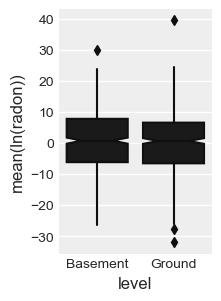

In [29]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=readings, x='type', y='apriori', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>

### Modelling

References:
* [pymc.sample](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html)

In [30]:
with complete:
    
    # starting off with the default sample settings
    trace = pm.sample(draws=1000, cores=None, tune=1000)

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-11-21 23:05:11.587

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-11-21 23:05:11.590

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-11-21 23:05:14.793

NUTS: [apriori, sigma]

NUTS: [apriori, sigma]
2022-11-21 23:05:14.794



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
2022-11-21 23:05:45.248



<br>

Hence

In [31]:
logger.info(trace.keys())


KeysView(Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data)
2022-11-21 23:05:51.182



<br>

**Mapping level names & level codes**

In [32]:
# codes = np.arange(trace.posterior.LevelName.shape[0])
# logger.info(trace.posterior['LevelName'][codes])

trace.posterior = trace.posterior.assign_coords(LevelCode=list(coords['LevelName'].values()))

<br>

**Extending the `trace` object**: The `trace` object will be the core inference object, combining the `trace` & `inferences` objects $\longrightarrow$

In [33]:
trace.extend(inferences)

<br>

### Traces, Metrics, Measures


Notes/references:

* [About `arviz.hdi(.)`](https://arviz-devs.github.io/arviz/api/generated/arviz.hdi.html)

* [About `xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html#xarray.DataArray)

* [xarray.DataArray.groupy](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html#xarray.DataArray.groupby)

* cf. `trace.constant_data['level']` & `trace.constant_data['N']`


<br>

**Trace**

In [34]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
apriori[Basement],1.362,0.029,1.308,1.417,0.000,0.000,5120.0,2847.0,1.0
apriori[Ground],0.776,0.065,0.651,0.891,0.001,0.001,6376.0,3051.0,1.0
sigma,0.791,0.018,0.757,0.825,0.000,0.000,5811.0,3161.0,1.0


<br>

Or, graphs.

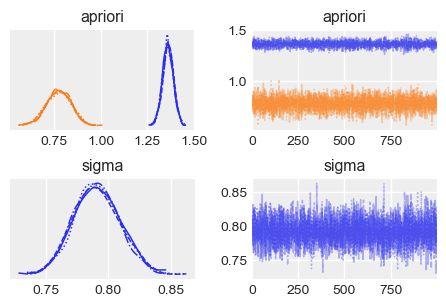

In [35]:
with complete:
    az.plot_trace(data=trace, figsize=(4.35, 2.95))

<br>

Cf.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000014247250>,
      dtype=object)

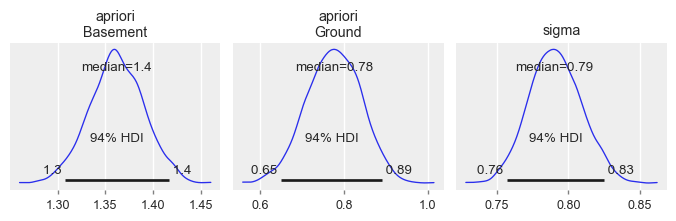

In [36]:
pm.plot_posterior(data=trace, var_names=['apriori', 'sigma'], 
                 figsize=(6.65, 2.1), grid=(1, 3), point_estimate='median', textsize=9)

<br>
<br>

**Posterior Predictive Samples**

In [37]:
with complete:
    ppc = pm.sample_posterior_predictive(trace)

Sampling: [y]

Sampling: [y]
2022-11-21 23:05:55.050



<br>

Hence, the resulting inferences

In [38]:
logger.info(ppc.keys())


KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data)
2022-11-21 23:05:55.821



<br>

Append the latest inference data to the core inference object, i.e., `trace`

In [39]:
trace.extend(ppc)

<br>
<br>

**Posterior Predictive Check**

Equivalent:
> ```python 
pm.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

> ```python 
az.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

<br>

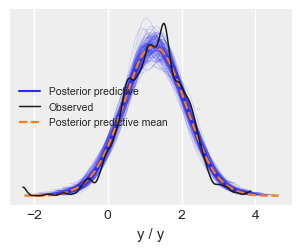

In [40]:
az.plot_ppc(data=trace, figsize=(2.9, 2.4), num_pp_samples=125, random_seed=RANDOM_SEED, textsize=10)

<br>

The posterior predictive high density interval per floor level type

In [41]:
credibility = lambda x: az.hdi(x, input_core_dims=[["chain", "draw", "N"]])
hdi_measure = (
    trace.posterior_predictive.y.groupby(trace.constant_data.levelcode)
    .apply(credibility)
    .y
)
hdi_measure

<xarray.DataArray 'y' (levelcode: 2, hdi: 2)>
array([[-0.12033861,  2.85919296],
       [-0.71827805,  2.27393115]])
Coordinates:
  * hdi        (hdi) <U6 'lower' 'higher'
  * levelcode  (levelcode) int64 0 1

<br>
<br>

**Posterior Mean**

In [42]:
averages_features = trace.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:    (LevelName: 2, LevelCode: 2)
Coordinates:
  * LevelName  (LevelName) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
Data variables:
    apriori    (LevelName) float64 1.362 0.7755
    sigma      float64 0.791

<br>

**Posterior Check**

Herein, determining the high density posterior intervals via

> ```python
hdi_features = (
    trace.posterior.apriori.groupby(trace.posterior.LevelName).apply(
        lambda x: az.hdi(x, input_core_dims=[['chain', 'draw']])).apriori
)
hdi_features


is unnecessarily complex, and the resulting object does not include `LevelCode` co$\ddot{o}$rdinates.

<br>


In [43]:
hdi_features = az.hdi(trace)
hdi_features

<xarray.Dataset>
Dimensions:    (LevelName: 2, hdi: 2, LevelCode: 2)
Coordinates:
  * LevelName  (LevelName) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
  * hdi        (hdi) <U6 'lower' 'higher'
Data variables:
    apriori    (LevelName, hdi) float64 1.308 1.417 0.6506 0.8905
    sigma      (hdi) float64 0.7571 0.825

<br>

### Structuring


Co$\ddot{o}$rdinates & Labels

* [xarray API](https://docs.xarray.dev/en/stable/api.html)

* [xarray.Dataset.assign_coords](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.assign_coords.html#xarray.Dataset.assign_coords)



In [44]:
labels = trace.posterior['LevelName'][trace.constant_data['levelcode']]

<br>

Preferable?

In [45]:
trace.observed_data = trace.observed_data.assign_coords(LevelName=labels)
trace.observed_data = trace.observed_data.assign_coords(LevelCode=trace.constant_data['levelcode'])
trace.observed_data = trace.observed_data.sortby('LevelCode')

<br>

### Graphs

Options:

* `sns.scatterplot(y=trace.observed_data['y'], x=trace.observed_data['LevelName'], ax=ax)`

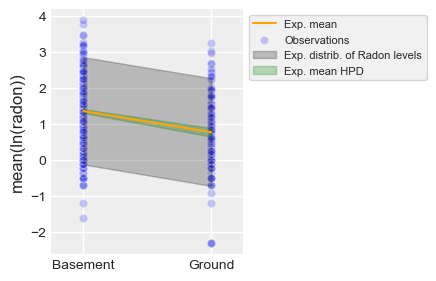

In [46]:
ax = sketch.figure(width=4.25, height=2.7)

trace.observed_data.plot.scatter(x='LevelCode', y='y', label='Observations', alpha=0.25, ax=ax)

az.plot_hdi(hdi_measure.levelcode.values, 
            hdi_data=hdi_measure, 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. distrib. of Radon levels'}, 
            color='k',
            ax=ax)

az.plot_hdi(hdi_features.LevelCode.values, 
            hdi_data=hdi_features['apriori'], 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. mean HPD'}, 
            color='green',
            ax=ax)

ax.plot(np.arange(averages_features.coords['LevelName'].shape[0]), 
        averages_features['apriori'].values, 
        color='orange',
        label='Exp. mean')

sketch.annotation(ax, Labels(title='', xlabel='', ylabel='mean(ln(radon))'))

ax.set_xlim(-0.25, 1.25)

ax.set_xticks(trace.posterior['LevelCode'].values)
ax.set_xticklabels(trace.posterior['LevelName'].values, rotation=0)

ax.legend(fontsize=8, frameon=True, bbox_to_anchor=(1, 1), loc='upper left')

<br>

### Inference Data

In [47]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

## Unpooled

<br>

Determine the distinct set of counties, subsequently assign a distinct index to each.  In future use [an appropriate geographic code](https://www.nist.gov/system/files/documents/2021/08/11/FIPSCodesReplacementChart2015.pdf).

In [48]:
counties = excerpt['county'].unique()
indices = range(len(counties))
dictionary = dict(zip(counties, indices))

<br>

Hence, append a county index field to `excerpt`.

In [49]:
excerpt.loc[:, 'countyindex'] = excerpt['county'].replace(dictionary)

<br>

### Model

Adding the set of distinct county names to the `coords` object.

In [50]:
coords['County'] = counties
coords['County'] = dictionary
logger.info(coords.keys())


dict_keys(['LevelName', 'County'])
2022-11-21 23:06:00.415



<br>

Hence

In [51]:
with pm.Model(coords=coords) as unpooled:
    
    
    # the values of the <floor> field
    levelcode = pm.Data(name='levelcode', value=excerpt.floor.values, dims='N', mutable=True)
    logger.info(levelcode.get_value().shape)
    logger.info(levelcode.type())
    
    
    # the values of the <countyindex> field
    countyindex = pm.Data(name='countyindex', value=excerpt.countyindex.values, dims='N', mutable=True)
    logger.info(countyindex.get_value().shape)
    logger.info(countyindex.type())
    
    
    # <apriori> probably has two elements - the object <Dwelling> has two elements, therefore two random values from a normal distribution
    apriori = pm.Normal(name='apriori', mu=0.0, sigma=10.0, dims=('County', 'LevelName'))
    
    
    # shape(mu) === shape(floor)
    mu = apriori[countyindex, levelcode]
    
    
    # model
    # pm.Exponential(name=, lam=)
    sigma = pm.Exponential('sigma', 1.0)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=excerpt['ln_radon'].values, dims='N')



(919,)
2022-11-21 23:06:00.430


<TensorType(int32, (None,))>
2022-11-21 23:06:00.431


(919,)
2022-11-21 23:06:00.433


<TensorType(int32, (None,))>
2022-11-21 23:06:00.434



<br>
<br>

Is this the correct seeding method/approach?

In [52]:
unpooled.initial_point(seed=RANDOM_SEED);

<br>

Previews

In [53]:
logger.info(f'The groups: {apriori.eval().shape}')
logger.info('The shape of mu: %s', mu.eval().shape)


The groups: (85, 2)
2022-11-21 23:06:00.554


The shape of mu: (919,)
2022-11-21 23:06:00.584



<br>

Illustration of model

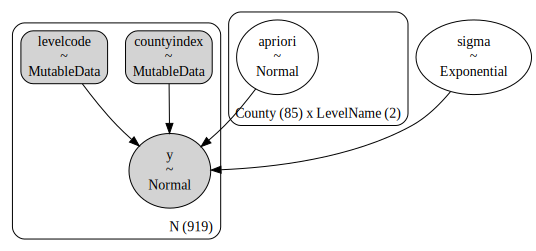

In [54]:
pm.model_to_graphviz(unpooled)

<br>

### Modelling

In [55]:
with unpooled:
    
    # starting off with the default sample settings
    alternative = pm.sample(draws=1000, cores=None, tune=1000)


Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-11-21 23:06:01.937

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-11-21 23:06:01.939

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-11-21 23:06:05.246

NUTS: [apriori, sigma]

NUTS: [apriori, sigma]
2022-11-21 23:06:05.248



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
2022-11-21 23:06:55.784



<br>

### Traces, Metrics, Measures

In [56]:
az.summary(alternative)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"apriori[AITKIN, Basement]",0.669,0.407,-0.092,1.431,0.006,0.005,5125.0,3153.0,1.0
"apriori[AITKIN, Ground]",0.837,0.721,-0.567,2.128,0.010,0.009,4873.0,2666.0,1.0
"apriori[ANOKA, Basement]",0.949,0.101,0.765,1.133,0.001,0.001,4755.0,2763.0,1.0
"apriori[ANOKA, Ground]",-0.126,0.415,-0.949,0.616,0.006,0.007,4422.0,2917.0,1.0
"apriori[BECKER, Basement]",1.469,0.710,0.211,2.814,0.011,0.009,3895.0,2754.0,1.0
...,...,...,...,...,...,...,...,...,...
"apriori[WRIGHT, Basement]",1.679,0.202,1.275,2.026,0.003,0.002,4709.0,3115.0,1.0
"apriori[WRIGHT, Ground]",0.863,0.723,-0.495,2.186,0.010,0.009,4772.0,3031.0,1.0
"apriori[YELLOW MEDICINE, Basement]",1.212,0.505,0.272,2.142,0.008,0.006,4330.0,2925.0,1.0
"apriori[YELLOW MEDICINE, Ground]",-0.098,9.853,-18.502,18.683,0.151,0.165,4261.0,2841.0,1.0


<br>

Or, graphs.

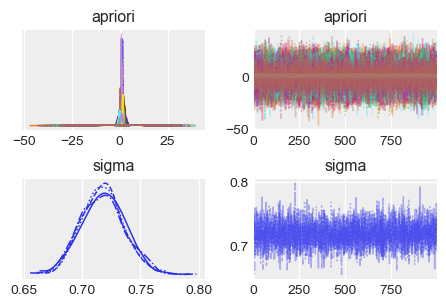

In [57]:
with unpooled:
    az.plot_trace(data=alternative, figsize=(4.35, 2.95))

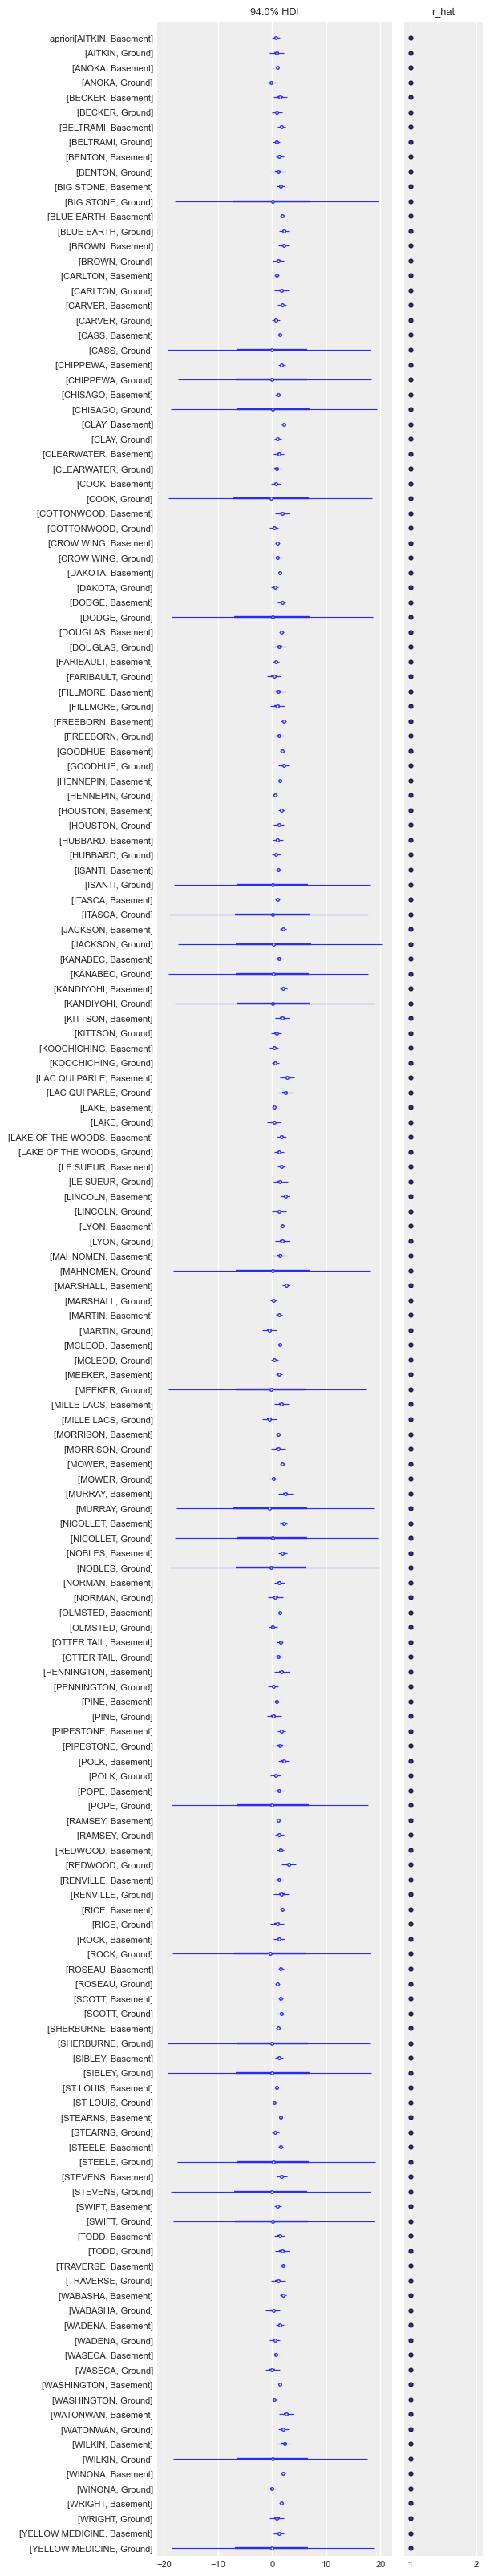

In [58]:
az.plot_forest(
    alternative, var_names='apriori', figsize=(6, 32), r_hat=True, combined=True, textsize=8
);

<br>

**Posterior Mean**

In [59]:
averages_features = alternative.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:    (County: 85, LevelName: 2)
Coordinates:
  * County     (County) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * LevelName  (LevelName) <U8 'Basement' 'Ground'
Data variables:
    apriori    (County, LevelName) float64 0.6686 0.837 ... 1.212 -0.09768
    sigma      float64 0.7176

<br>

**Posterior Check**

In [60]:
hdi_features = az.hdi(alternative)
hdi_features

<xarray.Dataset>
Dimensions:    (County: 85, LevelName: 2, hdi: 2)
Coordinates:
  * County     (County) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * LevelName  (LevelName) <U8 'Basement' 'Ground'
  * hdi        (hdi) <U6 'lower' 'higher'
Data variables:
    apriori    (County, LevelName, hdi) float64 -0.09179 1.431 ... -18.5 18.68
    sigma      (hdi) float64 0.6834 0.7516

<br>
<br>

### Graphs

**Generic**

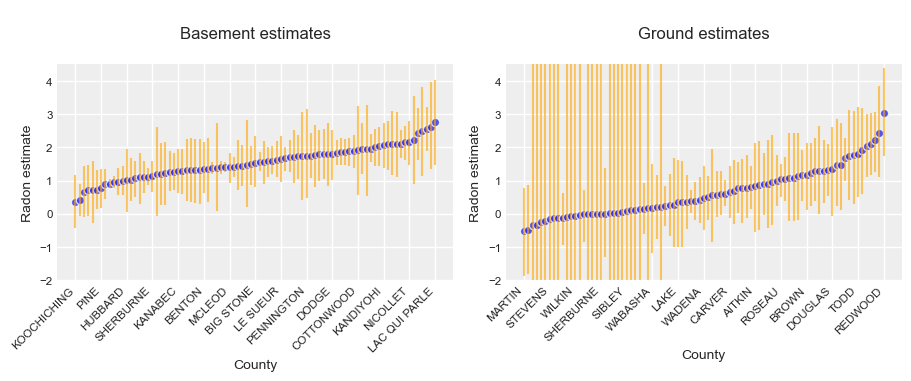

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.7))

xticks = np.arange(0, 86, 6)

fontdict = {'horizontalalignment': 'right', 'fontsize': 8}

for ax, level in zip(axes, ['Basement', 'Ground']):
    
    averages_ = averages_features.sel(LevelName=level).sortby('apriori')
    hdi_ = hdi_features.sel(LevelName=level).sortby(averages_.apriori)
    averages_.plot.scatter(x='County', y='apriori', ax=ax, alpha=0.8)
    
    ax.vlines(
        np.arange(len(counties)),
        hdi_.apriori.sel(hdi='lower'),
        hdi_.apriori.sel(hdi='higher'),
        color='orange',
        alpha=0.6,
    )
    
    
    # titles
    ax.set_title(f'\n{level.title()} estimates\n', fontsize=12)
    
    # x ticks
    ax.set_xticks(xticks)
    ax.set_xticklabels(averages_.County.values[xticks], horizontalalignment='right', rotation=45)
    
    # all ticks
    ax.tick_params(labelsize='x-small')
    
    # limits
    ax.set_ylim(bottom=-2, top=4.5)
    
    # labels
    ax.set_xlabel('County', fontsize=10)
    ax.set_ylabel('Radon estimate', fontsize=10)

<br>

**Funnel**

In [62]:
frequencies = excerpt[['county', 'floor']].groupby(by=['county', 'floor']).value_counts()
frequencies.rename('N', inplace=True)
frequencies = frequencies.to_frame()
frequencies.reset_index(drop=False, inplace=True)
logger.info(frequencies.head())


   county  floor   N
0  AITKIN      0   3
1  AITKIN      1   1
2   ANOKA      0  49
3   ANOKA      1   3
4  BECKER      0   1
2022-11-21 23:07:35.961



In [63]:
alternative

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data